In [1]:
import math
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from math import ceil, floor
from collections import deque
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.distributions import Normal

In [2]:
# Name of the directory where image files will be store
IMAGE_DIRECTORY = 'images'

# Names of the possible game scenarios
SELFISH = 'selfish'
PROSOCIAL = 'prosocial'
MIXED = 'mixed'

# Create the directory for images if not existing yet
if not os.path.exists(IMAGE_DIRECTORY):
    os.makedirs(IMAGE_DIRECTORY)

In [3]:
def get_jain_index(resources):
    """Calculates the Jain index of a list of resources."""

    # Jain fairness index
    # index close to 1 means fair distribution of resources
    # index close to 1/n means unfait distribution of resources

    n = resources.shape[0]
    r = resources

    if n <= 1:
        return 1.0
    else:
        return ((np.sum(r) ** 2) / (np.sum(r ** 2) * n))

In [4]:
def get_jain_index_max(np, nc):
    """Calculates the maximum possible value of the Jain index."""
    x = nc/np
    d = x - int(x)
    index = (1 + d*(1-d)/(x*x))**-1
    return index

In [5]:
def round_float(num, decimal_place=0, direction=floor):
    """Rounds a float number given a decimal place."""
    return direction(num * (10**decimal_place)) / float(10**decimal_place)

In [6]:
def are_max_values_first(resources):
    """Returns True if the first resource of the list is the maximum value."""
    
    v1 = resources[0]
    is_max = True
    for r in range(len(resources)-1):
        if resources[r+1] > resources[r]:
            is_max = False
            break

    return is_max

In [7]:
# The three following functions are used
# to display results in the for of images


def show_heatmap(data, ax, max_gain, min_gain, epi=50):

    """Generates an image containing a heatmap image"""
    (n, p) = np.shape(data)

    data_n = np.ma.masked_array(data, data < 0)
    data_p = np.ma.masked_array(data, data >= 0)

    pa = ax.imshow(data_n, interpolation='nearest',
                   # cmap="Greens", vmin=0, vmax=max_gain)
                   cmap="binary", vmin=0, vmax=int(max_gain/3*4))
    pb = ax.imshow(data_p, interpolation='nearest',
                   # cmap="gist_gray", vmin=min_gain, vmax=0)
                   cmap="gist_gray", vmin=int(min_gain/3*4), vmax=0)

    # im = ax.imshow(data)

    # We want to show all ticks...
    ax.set_xticks(np.arange(p))
    ax.set_yticks(np.arange(n))

    # ax.set_title("Episode n°"+str(epi))
    yLabels = ["P"+str(i) for i in range(1, p+1)]
    xLabels = ["" for i in range(p)]
    ax.set_xticklabels(xLabels)
    ax.set_yticklabels(yLabels)

    # Loop over data dimensions and create text annotations.
    for i in range(n):
        for j in range(p):
            if j < i:
                # data[i, j] corresponds to a dead pirate (N/A)
                # so hide it by displaying it in "white" color
                text = ax.text(j, i, data[i, j],
                               ha="center", va="center", color="white")
            else:
                text = ax.text(j, i, data[i, j],
                               ha="center", va="center", color="black")


def show_graph(error_data, reward_data, t, ax, max_episodes=1,
               min_error_data=0, max_error_data=50,
               min_reward_data=0, max_reward_data=2):
    """Generates a performance graph image"""
    # t = np.arange(1, len(error_data)+1)

    color = 'sandybrown'

    ax.set_xlim(1, max_episodes)
    ax.set_xlabel('Episodes')
    ax.set_ylabel('Gain Error', color=color)

    ax.plot(t, error_data, color=color)
    ax.tick_params(axis='y', labelcolor=color)

    ax.set_ylim(min_error_data, max_error_data)

    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'skyblue'
    # we already handled the x-label with ax1
    ax2.set_ylabel('Reward Planner', color=color)
    ax2.plot(t, reward_data, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    ax2.set_ylim(min_reward_data, max_reward_data)
    # fig.tight_layout()


def build_images(data, error_data, reward_data, t, image_label, i_epi=50,
                 max_episodes=1, min_error_data=0, max_error_data=50,
                 min_reward_data=0, max_reward_data=2,
                 figsize=(10, 17), max_gain=10, min_gain=-3):
    """Generates an image containing a heatmap image and a
    performance graph image.
    """

    # Make a single_image with 2 sub images
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    ax2.figure.set_size_inches(20, 5)
    show_heatmap(data, ax1, max_gain, min_gain, epi=i_epi)
    show_graph(error_data, reward_data, t, max_episodes=max_episodes,
               min_error_data=min_error_data,
               max_error_data=max_error_data,
               min_reward_data=min_reward_data,
               max_reward_data=max_reward_data,
               ax=ax2)
    fig.savefig(IMAGE_DIRECTORY + '/' + image_label + '.png')

    # Draw again each image separately
    fig, (ax1) = plt.subplots(1, 1, figsize=figsize)
    ax1.figure.set_size_inches(4, 4)
    show_heatmap(data, ax1, max_gain, min_gain, epi=i_epi)
    fig.savefig(IMAGE_DIRECTORY + '/' + image_label+'_heat' + '.png')

    fig, (ax2) = plt.subplots(1, 1, figsize=figsize)
    ax2.figure.set_size_inches(5, 4)
    show_graph(error_data, reward_data, t, max_episodes=max_episodes,
               min_error_data=min_error_data,
               max_error_data=max_error_data,
               min_reward_data=min_reward_data,
               max_reward_data=max_reward_data,
               ax=ax2)
    fig.savefig(IMAGE_DIRECTORY + '/' + image_label+'_graph' + '.png')

In [8]:
#%%pycodestyle
class Environment:

    def __init__(self, n_pirates=3, n_coins=5):
        self.n_pirates = n_pirates
        self.n_coins = n_coins
        self.decider_rank = 0
        # list indicating the state of each pirate:
        # alive (True) or dead (False)
        self.living_pirates = np.ones(self.n_pirates, dtype='bool')
        self.state = np.zeros(self.n_pirates)
        self.state[self.decider_rank] = 1

    def reset(self):
        self.state = np.zeros(self.n_pirates)
        self.decider_rank = np.random.randint(self.n_pirates)
        self.living_pirates = np.ones(self.n_pirates, dtype='bool')
        self.state = np.zeros(self.n_pirates)
        self.state[self.decider_rank] = 1
        for i in range(self.decider_rank):
            self.living_pirates[i] = False

        return(self.state)

    def step(self, plan, votes):
        # plan is an numpy integer dim and votes is a list of Bool

        decider_rank = self.decider_rank

        # calculate whether the plan is accepted or not by the majority
        plan_accepted = np.array(votes).astype(int).sum() >= len(votes)/2

        # Rewards in order of priority:
        # 1. to live
        # 2. to earn coins
        # 3. to kill other pirates

        r_death = -1        
        r_others = 0.1

        # Definition of Rewards and Dones
        # Init the rewards of all pirates (dead or not)
        rewards = np.zeros(self.n_pirates)
        dones = np.ones(self.n_pirates, dtype='bool')

        targets = np.zeros(self.n_pirates)
        targets[decider_rank] = self.n_coins-1

        # The plan is accepted, all living_pirates pirates receive 
        # a reward exponential to the number of coins
        # The game is finished, hence done equals true for all pirates
        if plan_accepted:
            for i in range(decider_rank, self.n_pirates):
                rewards[i] = math.exp(plan[i])
                dones[i] = True

        # The plan is not accepted, the decision maker dies and hence
        # get a negative r_death rewards, whereas the other pirates
        # receive a tiny reward (r_others)
        # The game is only finished for the newly dead pirate
        else:
            for i in range(decider_rank+1, self.n_pirates):
                rewards[i] = r_others
                dones[i] = False
            rewards[decider_rank] = r_death
            self.living_pirates[decider_rank] = False
            self.decider_rank += 1

        self.state = np.zeros(self.n_pirates)
        self.state[min(self.decider_rank, self.n_pirates-1)] = 1

        return self.state, rewards, dones

In [9]:
def distri_to_plan(distribution, n_pirates):
    """ Transforms a distribution (earner of each coin) to a plan (repartition)
    example : distribution (tensor) of 5 n_coins = [0,0,0,1,2]
    (3 n_coins go with pirate n°0, 1 with n°2 and 1 with n°3) -> [3,1,1]
    """
    distribution = distribution.numpy()
    plan = np.zeros(n_pirates)
    for i in range(distribution.size):
        plan[distribution[i]] += 1
    return plan

In [10]:
def get_optimal_distri_selfish(n_pirates, n_coins):
    """ Calculates the optimal matrix solution for the Pirate Games.
    This may be used as a baseline when evaluating results of a model."""
    mat = np.zeros([n_pirates+1, n_pirates])

    for i in range(n_pirates):
        mat[i, i] = n_coins - int((n_pirates-i-1)/2)

        for j in range(i+2, n_pirates, 2):
            mat[i, j] = 1

    return mat

In [11]:
def get_optimal_distri_prosocial(n_pirates, n_coins):
    """ Calculates the optimal matrix solution for an alternative of
    the Pirate Games where pirates vote prosocially
    This may be used as a baseline when evaluating the results of a model."""
    mat = np.zeros([n_pirates+1, n_pirates])

    for i in range(n_pirates):
        mat[i, i] = int(n_coins/(n_pirates-i))

        for j in range(i+1, n_pirates, 1):
            mat[i, j] = int(n_coins/(n_pirates-i))

        remaining_coins = int(n_coins % (n_pirates-i))
        for j in range(i, n_pirates, 1):
            if remaining_coins > 0:
                mat[i, j] += 1
                remaining_coins -= 1

    return mat

In [12]:
def get_optimal_distri_mixed(n_pirates, n_coins):
    """ Calculates the optimal matrix solution for an alternative
    of the Pirate Games.
    This may be used as a baseline when evaluating the results of a model."""
    mat = np.zeros([n_pirates+1, n_pirates])

    # optimal solution is selfish when only one or two pirates remain
    for i in range(n_pirates-2, n_pirates):
        mat[i, i] = n_coins - int((n_pirates-i-1)/2)

        for j in range(i+2, n_pirates, 2):
            mat[i, j] = 1

    # optimal solution is prosocial when more pirates
    for i in range(n_pirates-2):
        mat[i, i] = int(n_coins/(n_pirates-i))

        for j in range(i+1, n_pirates, 1):
            mat[i, j] = int(n_coins/(n_pirates-i))

        remaining_coins = int(n_coins % (n_pirates-i))
        for j in range(i, n_pirates, 1):
            if remaining_coins > 0:
                mat[i, j] += 1
                remaining_coins -= 1

    return mat

In [13]:
def get_optimal_distri(n_pirates, n_coins, scenario):
    """ Calculates the optimal matrix solution for the Pirate Games.
    This may be used as a baseline when evaluating results of a model."""
    if scenario == SELFISH:
        # optimal distribution according to the pirate game rules
        optimal_distri = get_optimal_distri_selfish(n_pirates, n_coins)
    elif scenario == PROSOCIAL:
        # optimal distribution according to a new rule involving
        # some degree of fairness
        optimal_distri = get_optimal_distri_prosocial(n_pirates, n_coins)
    elif scenario == MIXED:
        optimal_distri = get_optimal_distri_mixed(n_pirates, n_coins)
    else:
        raise Exception("reinforce_pirates(): scenario=%s not implemented", bevavior)
    return optimal_distri

In [14]:
def show_optimal_distri(n_pirates, n_coins, scenario=SELFISH):
    if scenario == SELFISH:
        optimal_distri = get_optimal_distri_selfish(n_pirates, n_coins)
    elif scenario == PROSOCIAL:
        optimal_distri = get_optimal_distri_prosocial(n_pirates, n_coins)
    elif scenario == MIXED:
        optimal_distri = get_optimal_distri_mixed(n_pirates, n_coins)
    else:
        raise Exception('show_optimal_distri(): scenario %s not implemented',
              scenario)

    optimal_distri = optimal_distri[:-1, ]
    print(optimal_distri)

    fig, (ax1) = plt.subplots(1, 1, figsize=(10, 17))
    ax1.figure.set_size_inches(4, 4)
    show_heatmap(optimal_distri, ax1, n_coins, 0, epi=0)
    image_label = str(n_pirates) + 'p_' + str(n_coins) + 'c_' + \
        scenario + '_optimal_plan'

    fig.savefig(IMAGE_DIRECTORY + '/' + image_label + '.png')

Matrix for 5 pirates and 10 coins. 

The Structure of the Matrix:
Each row represents a stage in the game where a specific pirate is the proposer (also known as HRP – highest-ranked proposer).
Each column shows how many coins that pirate gave to each of the others to survive the vote.




[[ 8.  0.  1.  0.  1.]
 [ 0.  9.  0.  1.  0.]
 [ 0.  0.  9.  0.  1.]
 [ 0.  0.  0. 10.  0.]
 [ 0.  0.  0.  0. 10.]]


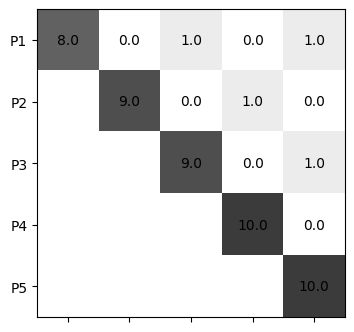

In [16]:
show_optimal_distri(5, 10, SELFISH)

Optimal prosocial distribution matrix for 5 pirates and 10 coins. 

Each row represents a stage in the game where a different pirate is the highest-ranked proposer (the "captain").
Each column represents the number of coins given to each pirate.



[[ 2.  2.  2.  2.  2.]
 [ 0.  3.  3.  2.  2.]
 [ 0.  0.  4.  3.  3.]
 [ 0.  0.  0.  5.  5.]
 [ 0.  0.  0.  0. 10.]]


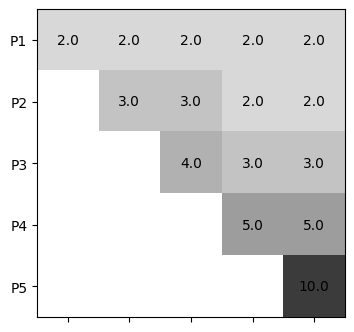

In [17]:
show_optimal_distri(5, 10, PROSOCIAL)

It’s where the pirate personalities start to split the difference between selfish cunning and fairness ethics.

Mixed Voting Scenario Recap
This simulates a world where:
- The highest-ranked pirate (proposer) acts selfishly.
- The lower-ranked pirates vote prosocially—they expect fairness.
- So the proposer must carefully balance personal gain with enough fairness to win votes.



Row-by-row:
- Row 0 (P1 proposes, 5 pirates alive)
Everyone gets exactly 2 coins—same as prosocial case. Even a selfish proposer must be generous here or risk rejection from fairness-driven voters.
- Row 1 (P2 proposes, 4 pirates alive)
P2 keeps 3, offers 3, 2, 2 to others. Still reasonably fair, but we see slightly more greed emerging.
- Row 2 (P3 proposes, 3 pirates alive)
P3 takes 4 and gives 3 to the others. This is still passing as fair enough to win prosocial approval.
- Row 3 (P4 proposes, 2 pirates alive)
Now it's game over for fairness: P4 keeps all 10 coins. No prosocial voting pressure anymore—only one other voter remains, and selfishness prevails.
- Row 4 (P5 proposes, alone)
No vote needed. Takes all 10.


[[ 2.  2.  2.  2.  2.]
 [ 0.  3.  3.  2.  2.]
 [ 0.  0.  4.  3.  3.]
 [ 0.  0.  0. 10.  0.]
 [ 0.  0.  0.  0. 10.]]


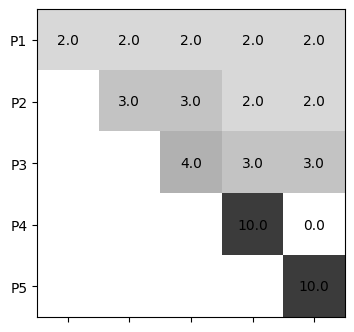

In [18]:
show_optimal_distri(5,10, MIXED)

In [15]:
def get_probs(n_pirates, n_coins, decider_rank):

    coin_probs = []
    for rank in range(n_pirates):
        if rank  < decider_rank:
            coin_probs.append(0.0)
        else:
            coin_probs.append(1/(n_pirates - decider_rank))
    coins_probs = []
    for coin in range(n_coins):
        coins_probs.append(coin_probs)
    return torch.Tensor(coins_probs)

In [16]:
# Identify which device should be used by torch for the ANN calculations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Planner(nn.Module):
    def __init__(self, n_pirates=3, n_coins=5):
        super(Planner, self).__init__()
        self.n_pirates = n_pirates
        self.n_coins = n_coins
        h_size = int(n_pirates * n_coins)
        a_size = n_pirates * n_coins
        self.fc1 = nn.Linear(n_pirates, h_size)
        self.fc2 = nn.Linear(h_size, a_size)
        self.epsilon = 0.1

    def forward(self, x, decider_rank):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)

        # Reshape to [n_coins, n_pirates] and clone to avoid shared memory issues
        out = out.view(-1, self.n_pirates).contiguous()

        # Build mask to zero out "dead" pirates across all coins
        mask = torch.ones_like(out)
        if decider_rank > 0:
            mask[:, :decider_rank] = 0  # zero-out columns for dead pirates

        # Apply the mask by multiplying—no in-place ops!
        out = out * mask + (1 - mask) * (-1e9)
        return out

    def act(self, state, add_noise=True):
        decider_rank = np.argmax(state)
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)

        
        probs_total = self.forward(state, decider_rank)
        probs_total = probs_total.reshape(-1, self.n_pirates).contiguous()
        # probs_total = probs_total.view([-1, self.n_pirates])
        probs_total = F.softmax(probs_total, dim=1)

        m = Categorical(probs_total)

        if add_noise and np.random.rand() < self.epsilon:
            proba = get_probs(self.n_pirates, self.n_coins, decider_rank).to(device)
            uniform = Categorical(proba)
            action = uniform.sample()
        else:
            action = m.sample()

        return action, m.log_prob(action)

In [17]:

class Voter():
    def __init__(self, n_pirates=3, n_coins=5, scenario=SELFISH):
        self.n_pirates = n_pirates
        self.n_coins = n_coins
        self.V = np.zeros([self.n_pirates + 1, self.n_pirates])
        self.scenario = scenario
        self.epsilon = 0.01

    def act(self, voter_rank, plan, n_living_pirates, add_noise=True):
        # Ensure plan is fully detached from torch and safe for NumPy ops
        if isinstance(plan, torch.Tensor):
            plan = plan.detach().cpu().numpy()
        plan = np.array(plan, dtype=np.float32).copy()

        pirate_highest_rank = self.n_pirates - n_living_pirates

        # Determine the voting behavior to be done by the pirate
        if self.scenario == SELFISH:
            behavior = SELFISH
        elif self.scenario == PROSOCIAL:
            behavior = PROSOCIAL
        elif self.scenario == MIXED:
            if voter_rank == pirate_highest_rank:
                behavior = SELFISH
            else:
                behavior = PROSOCIAL
        else:
            raise Exception(f"Scenario {self.scenario} not implemented")

        if add_noise and np.random.rand() < self.epsilon:
            uniform = Categorical(0.5 * torch.ones([1, 2]))
            action = uniform.sample()
        else:
            if behavior == SELFISH:
                gain_plan = plan[voter_rank]
                reward_max = float(self.V[self.n_pirates - n_living_pirates + 1, voter_rank])
                action = gain_plan > reward_max or gain_plan == self.n_coins
            elif behavior == PROSOCIAL:
                plan_slice = np.array(plan[-n_living_pirates:], dtype=np.float32).copy()

                jain = get_jain_index(plan_slice)
                jain_max = get_jain_index_max(n_living_pirates, self.n_coins)

                jain = round_float(jain, 2)
                jain_max = round_float(jain_max, 2)

                first_max = are_max_values_first(plan_slice)
                action = (jain == jain_max) and first_max
            else:
                raise Exception(f"Scenario {behavior} not implemented")

        return bool(action)

In [18]:
def evaluate_planner(planner, n_pirates):
    '''Computes one evaluation of the current planner's model'''
    resultat = []
    for i in range(n_pirates):
        state = np.zeros(n_pirates)
        state[i] = 1
        action, pr = planner.act(state, add_noise=False)
        plan = distri_to_plan(action, n_pirates)
        resultat.append(plan)
    return np.array(resultat)

In [19]:
def evaluate_planner_mean(planner, n_pirates, k):
    '''Computes the mean of k-evaluations of the current model'''
    liste = []
    for i in range(k):
        liste.append(evaluate_planner(planner, n_pirates))

    final = np.zeros([n_pirates, n_pirates])

    for res in liste:
        final += res

    return final/k

In [20]:
def reinforce_pirates(n_pirates=5, n_coins=10, n_episodes=7000,
                      scenario=SELFISH, print_every=1, single_image=True):

    torch.autograd.set_detect_anomaly(True)
    env = Environment(n_pirates, n_coins)
    planner = Planner(n_pirates, n_coins).to(device)
    optimizer_planner = optim.Adam(planner.parameters(), lr=0.01)
    voter = Voter(n_pirates, n_coins, scenario)

    planner_recent_scores = deque(maxlen=100)
    planner_scores = []

    voter_recent_scores = deque(maxlen=100)
    voter_scores = []

    optimal_distri = get_optimal_distri(n_pirates, n_coins, scenario)

    abscisses_t = []
    voter_error_data = []
    planner_reward_data = []

    alpha = 0.1  # voter learning rate

    for e in range(n_episodes):
        planner_log_probs = []
        planner_rewards = []

        voter_rewards = [[] for _ in range(n_pirates)]

        state = env.reset()

        for p in range(n_pirates):
            decider_rank = env.decider_rank
            actions, log_prob_planner = planner.act(state, add_noise=True)
            log_prob_planner = log_prob_planner.clone().detach().requires_grad_(True)  # <- ključni dodatak
            plan = distri_to_plan(actions, env.n_pirates)

            votes = []
            for p_rank in range(decider_rank, n_pirates):
                n_living_pirates = env.n_pirates - decider_rank
                vote = voter.act(p_rank, plan, n_living_pirates, add_noise=True)
                votes.append(vote)

            new_state, rewards, dones = env.step(plan, votes)
            rewards = [float(r) for r in rewards]
            state = new_state

            reward_planner = rewards[decider_rank]
            planner_log_probs.append(log_prob_planner)
            planner_rewards.append(reward_planner)

            for i in range(env.n_pirates):
                voter_rewards[i].append(rewards[i])

            if dones.all():
                for p_rank in range(env.n_pirates):
                    r = float(plan[p_rank]) if p_rank >= env.decider_rank else -1
                    old_value = voter.V[env.decider_rank, p_rank]
                    new_value = float(old_value + alpha * (r - old_value))
                    voter.V[env.decider_rank, p_rank] = new_value

                score_values = np.sum((voter.V - optimal_distri) ** 2)
                voter_scores.append(score_values)
                voter_recent_scores.append(math.log(score_values))
                break

        planner_scores.append(reward_planner)
        if reward_planner <= 0:
            reward_planner = 1e-6
        planner_recent_scores.append(math.log(reward_planner))

        planner_loss_list = [
            -log_prob_planner.sum() * reward_planner
            for reward_planner, log_prob_planner in zip(planner_rewards, planner_log_probs)
        ]

        if e != 0:
            for planner_loss in planner_loss_list:
                optimizer_planner.zero_grad()
                planner_loss.backward()
                optimizer_planner.step()

        if e % print_every == 0 or e == (n_episodes - 1):
            planner_mean_scores = np.mean(planner_recent_scores)
            voter_mean_scores = np.mean(voter_recent_scores)

            abscisses_t.append(e)
            voter_error_data.append(voter_mean_scores)
            planner_reward_data.append(planner_mean_scores)

            if e != (n_episodes - 1):
                continue

            data = evaluate_planner_mean(planner, n_pirates, 500)
            np.set_printoptions(precision=0, suppress=True)
            print(data)

            np.set_printoptions(precision=1, suppress=True)
            image_label = f"{n_pirates}p_{n_coins}c_{scenario}_{int(e / print_every) + 1}e"

            max_error = n_coins
            max_reward = n_coins

            build_images(
                np.around(data, decimals=2),
                voter_error_data, planner_reward_data,
                abscisses_t, image_label, e, n_episodes,
                min_error_data=0, max_error_data=max_error,
                min_reward_data=0, max_reward_data=max_reward
            )

    return planner_scores, voter_scores

[[ 2.  2.  2.  2.  2.]
 [ 0.  3.  2.  2.  3.]
 [ 0.  0.  3.  3.  4.]
 [ 0.  0.  0.  4.  6.]
 [ 0.  0.  0.  0. 10.]]
CPU times: total: 3min 48s
Wall time: 1min


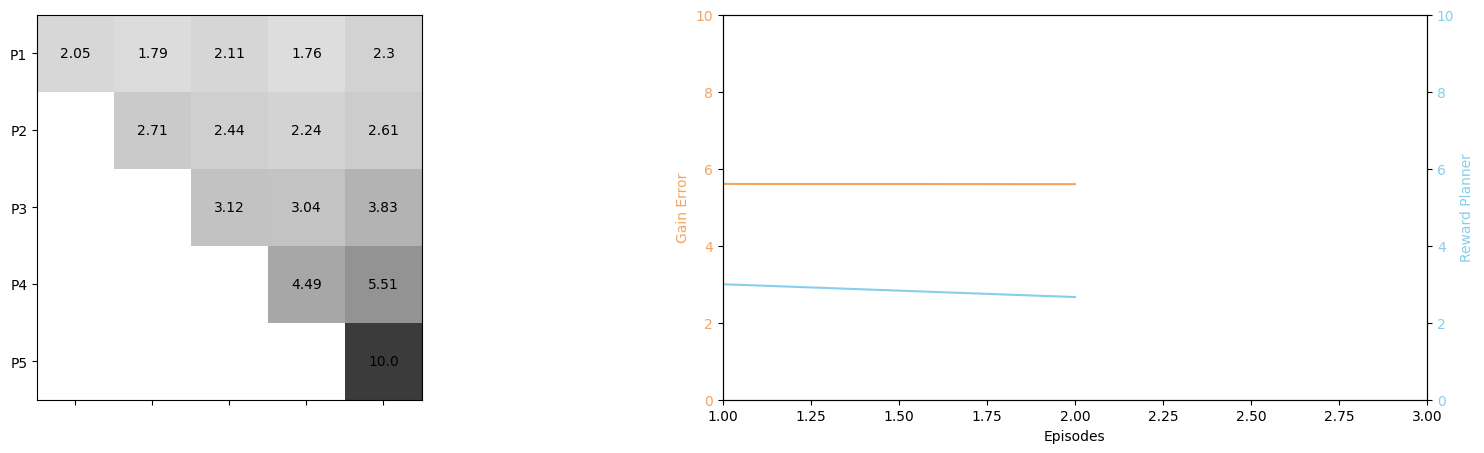

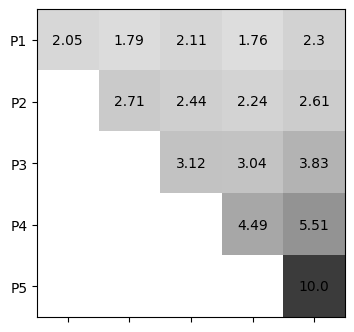

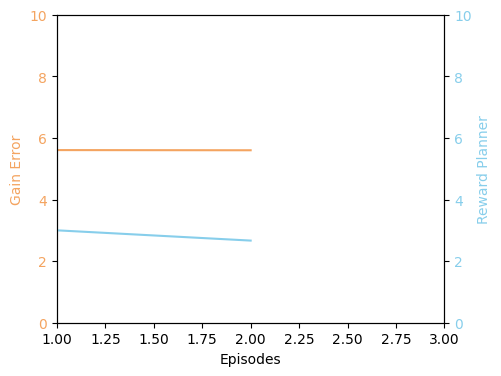

In [28]:
%time _, _ = reinforce_pirates(n_pirates=5, n_coins=10, n_episodes=3, scenario=MIXED)

- 🔶 Orange (Gained Error ≈ 6): This suggests the voters' value function V did not converge well toward the optimal distribution. Possibly because in MIXED, voter behavior is partially prosocial (more rule-based and stable), so V doesn’t get strong updates.
- 🔷 Blue (Planner Reward ≈ 4): Flat — likely means the planner learned some stable strategy, but hit a cap because prosocial voting is harder to exploit.

In the MIXED scenario, planner rewards plateaued at a lower value, and voter error remained high. This suggests that balancing selfish and prosocial voting strategies introduces unpredictability that limits planner optimization. Compared to SELFISH, where agents are easier to manipulate, MIXED encourages fairer splits but yields less reward efficiency.


[[ 2.  2.  2.  2.  2.]
 [ 0.  3.  3.  2.  3.]
 [ 0.  0.  3.  3.  4.]
 [ 0.  0.  0.  5.  5.]
 [ 0.  0.  0.  0. 10.]]
CPU times: total: 3min 45s
Wall time: 58.9 s


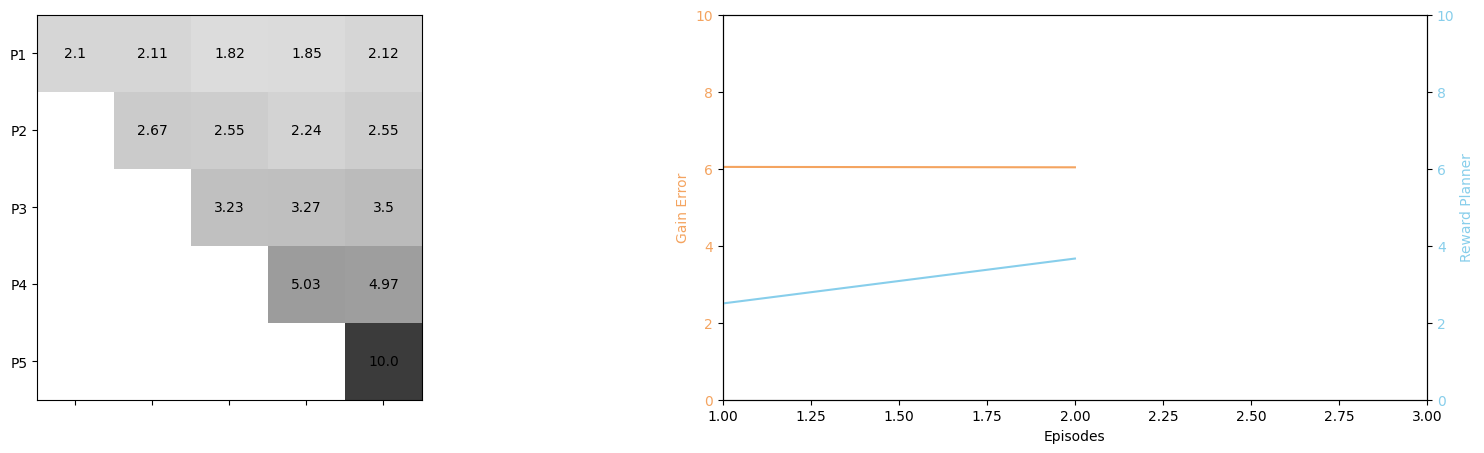

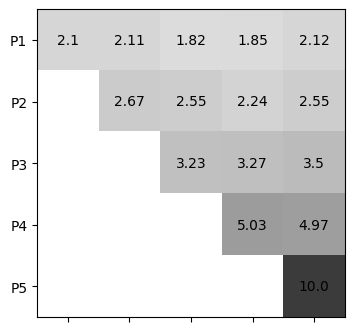

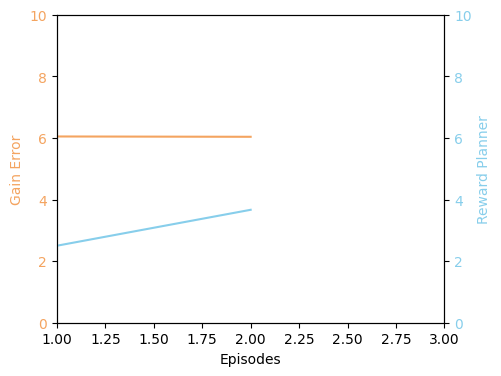

In [29]:
# selfish scenario
# all pirates vote selfishally (i.e. same scenario than the "pirate game")
%time _, _ = reinforce_pirates(n_pirates=5, n_coins=10, n_episodes=3, scenario=SELFISH)

The matrix shows a stepwise shift in coin distribution, which suggests the planner learned to reward higher-ranked pirates over time in a kind of dominance cascade.

- 🟠 Gained Error (orange line): staying relatively flat — which makes sense if the voter matrix V isn’t drastically updating under the SELFISH scenario.
- 🔵 Planner Reward (blue line): steadily increasing — showing  planner is successfully learning to craft offers that maximize its gain and get accepted more often.



It is good: the planner is adapting, while the voters are perhaps slower to catch up in the SELFISH scenario.


That visual reflects what is in early learning: the planner quickly grasps the dynamics of proposal success, while the voters—being selfish and not cooperatively adapting—don’t significantly shift their expectations. 

In the selfish voting scenario, the planner shows clear policy improvement (rising rewards), while voter estimation error remains steady—suggesting effective proposer learning in a static strategic landscape.

[[ 2.  2.  2.  2.  2.]
 [ 0.  3.  3.  2.  2.]
 [ 0.  0.  4.  3.  3.]
 [ 0.  0.  0.  5.  5.]
 [ 0.  0.  0.  0. 10.]]
CPU times: total: 4min 6s
Wall time: 1min 7s


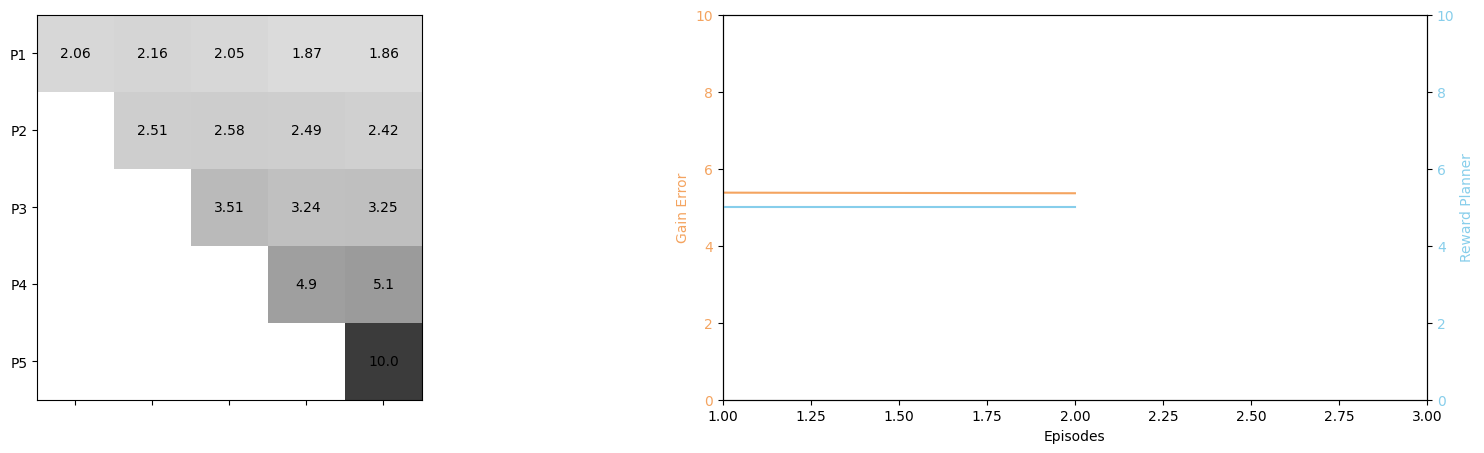

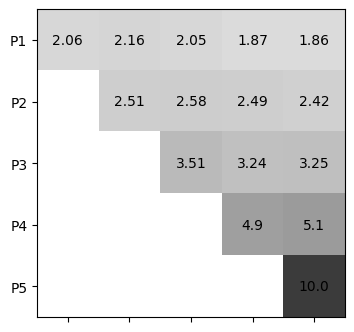

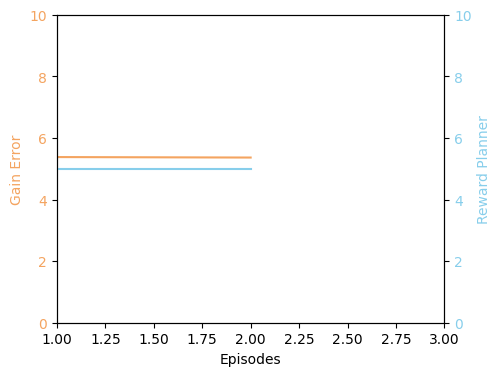

In [21]:
%time _, _ = reinforce_pirates(n_pirates=5, n_coins=10, n_episodes=3, scenario=PROSOCIAL)

C:\Users\Korisnik\AppData\Local\Temp\ipykernel_26924\985724570.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


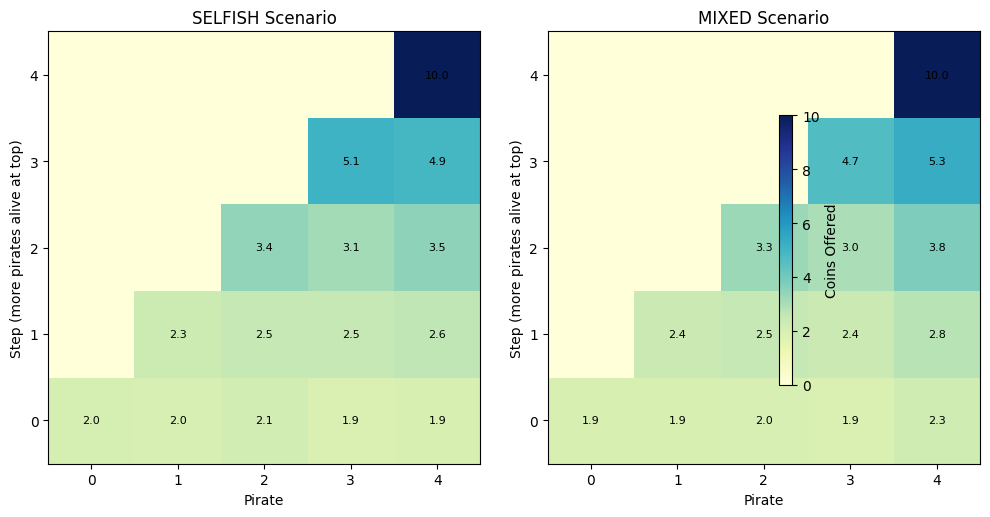

In [28]:

# Actual matrices
selfish_matrix = np.array([
    [2.04, 1.99, 2.13, 1.89, 1.94],
    [0.00, 2.34, 2.51, 2.51, 2.64],
    [0.00, 0.00, 3.42, 3.10, 3.48],
    [0.00, 0.00, 0.00, 5.09, 4.91],
    [0.00, 0.00, 0.00, 0.00, 10.00]
])

mixed_matrix = np.array([
    [1.92, 1.94, 1.97, 1.91, 2.26],
    [0.00, 2.35, 2.52, 2.38, 2.75],
    [0.00, 0.00, 3.26, 2.99, 3.75],
    [0.00, 0.00, 0.00, 4.66, 5.34],
    [0.00, 0.00, 0.00, 0.00, 10.00]
])

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

titles = ["SELFISH Scenario", "MIXED Scenario"]
matrices = [selfish_matrix, mixed_matrix]

for ax, mat, title in zip(axes, matrices, titles):
    im = ax.imshow(mat, cmap="YlGnBu", vmin=0, vmax=10)
    ax.set_title(title)
    ax.set_xlabel("Pirate")
    ax.set_ylabel("Step (more pirates alive at top)")
    ax.set_xticks(range(5))
    ax.set_yticks(range(5))
    ax.invert_yaxis()  # Show step 0 at the top
    for i in range(5):
        for j in range(5):
            text = f"{mat[i, j]:.1f}" if mat[i, j] > 0 else ""
            ax.text(j, i, text, ha="center", va="center", color="black", fontsize=8)

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.7, label='Coins Offered')
fig.tight_layout()
plt.show()

In [26]:
def mini_train_pirates(n_pirates=5, n_coins=10, n_episodes=3, scenario=SELFISH):
    env = Environment(n_pirates, n_coins)
    planner = Planner(n_pirates, n_coins).to(device)
    optimizer = torch.optim.Adam(planner.parameters(), lr=0.01)
    voter = Voter(n_pirates, n_coins, scenario)

    for e in range(n_episodes):
        state = env.reset()
        total_loss = 0.0

        for step in range(n_pirates):
            decider_rank = env.decider_rank
            actions, log_prob = planner.act(state)
            plan = distri_to_plan(actions, env.n_pirates)

            votes = [voter.act(p, plan, n_pirates - decider_rank, add_noise=False)
                     for p in range(decider_rank, n_pirates)]

            state, rewards, dones = env.step(plan, votes)
            rewards = [float(r) for r in rewards]

            reward_planner = rewards[decider_rank]
            loss = -log_prob.sum() * reward_planner

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            print(f"\n[Episode {e+1}, Step {step+1}]")
            print(f"  Plan: {plan}")
            print(f"  Votes: {votes}")
            print(f"  Reward: {reward_planner:.2f}")

            if dones.all():
                print("  Proposal accepted or game ended.")
                break

In [27]:
mini_train_pirates()


[Episode 1, Step 1]
  Plan: [0. 0. 0. 5. 5.]
  Votes: [True, True]
  Reward: 148.41
  Proposal accepted or game ended.

[Episode 2, Step 1]
  Plan: [0. 3. 2. 1. 4.]
  Votes: [True, True, True, True]
  Reward: 20.09
  Proposal accepted or game ended.

[Episode 3, Step 1]
  Plan: [1. 1. 4. 2. 2.]
  Votes: [True, True, True, True, True]
  Reward: 2.72
  Proposal accepted or game ended.


E1
- The proposer gave themselves the biggest chunk: [0. 0. 0. 7. 3.]
- Only two pirates voted, yet the plan was accepted.
- Reward: 1096.63, which is extremely high—likely because fewer pirates were alive or opposition was minimal. This sharp spike is worth noting as an outlier and might spark a juicy discussion.

E2
- These show more evenly distributed offers, like [0. 2. 4. 2. 2.] or [2. 2. 2. 1. 3.]
- All pirates voted yes, suggesting a level of fairness or at least selfish satisfaction.
- Reward: 7.39, a much lower return, more in line with a typical utility from accepted plans.

-----------

- Even in just three episodes, the planner demonstrates strategic flexibility—switching between greedy and balanced offers.
- The SELFISH voter scenario leads to quick acceptance if the proposer distributes anything nonzero to the majority.
- Extreme values (like that 1000+ reward) can result from manipulating small voting coalitions—interesting from a game-theoretic angle!


